In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# part a&b

In [74]:
import cv2
import numpy as np
import sys

class Image_Stitching():
    def __init__(self) :
        self.ratio=0.85
        self.min_match=10
        self.sift=cv2.xfeatures2d.SIFT_create()
        self.smoothing_window_size= 0

    def registration(self,img1,img2):
        kp1, des1 = self.sift.detectAndCompute(img1, None)
        kp2, des2 = self.sift.detectAndCompute(img2, None)
        matcher = cv2.BFMatcher()
        raw_matches = matcher.knnMatch(des1, des2, k=2)
        good_points = []
        good_matches=[]
        for m1, m2 in raw_matches:
            if m1.distance < self.ratio * m2.distance:
                good_points.append((m1.trainIdx, m1.queryIdx))
                good_matches.append([m1])
        img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good_matches, None, flags=2)
        cv2.imwrite('matching.jpg', img3)
        if len(good_points) > self.min_match:
            image1_kp = np.float32(
                [kp1[i].pt for (_, i) in good_points])
            image2_kp = np.float32(
                [kp2[i].pt for (i, _) in good_points])
            H, status = cv2.findHomography(image2_kp, image1_kp, cv2.RANSAC,5.0)
        return H

    def create_mask(self,img1,img2,version):
        height_img1 = img1.shape[0]
        width_img1 = img1.shape[1]
        width_img2 = img2.shape[1]
        height_panorama = height_img1
        width_panorama = width_img1 +width_img2
        offset = int(self.smoothing_window_size / 2)
        barrier = img1.shape[1] - int(self.smoothing_window_size / 2)
        mask = np.zeros((height_panorama, width_panorama))
        if version== 'left_image':
            mask[:, barrier - offset:barrier + offset ] = np.tile(np.linspace(1, 0, 2 * offset ).T, (height_panorama, 1))
            mask[:, :barrier - offset] = 1
        else:
            mask[:, barrier - offset :barrier + offset ] = np.tile(np.linspace(0, 1, 2 * offset ).T, (height_panorama, 1))
            mask[:, barrier + offset:] = 1
        return cv2.merge([mask, mask, mask])

    def blending(self,img1,img2):
        H = self.registration(img1,img2)
        height_img1 = img1.shape[0]
        width_img1 = img1.shape[1]
        width_img2 = img2.shape[1]
        height_panorama = height_img1
        width_panorama = width_img1 +width_img2

        panorama1 = np.zeros((height_panorama, width_panorama, 3))
        mask1 = self.create_mask(img1,img2,version='left_image')
        panorama1[0:img1.shape[0], 0:img1.shape[1], :] = img1
        panorama1 *= mask1
        mask2 = self.create_mask(img1,img2,version='right_image')
        panorama2 = cv2.warpPerspective(img2, H, (width_panorama, height_panorama))*mask2
        result=panorama1+panorama2

        rows, cols = np.where(result[:, :, 0] != 0)
        min_row, max_row = min(rows), max(rows) + 1
        min_col, max_col = min(cols), max(cols) + 1
        final_result = result[min_row:max_row, min_col:max_col, :]
        return final_result
def main(argv1,argv2):
    img1 = cv2.imread(argv1)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    
    img2 = cv2.imread(argv2)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    final=Image_Stitching().blending(img1,img2)
    return final


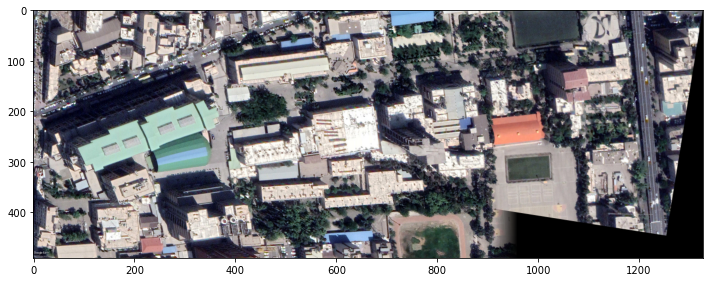

In [48]:
def normalize(image):
    return (image-image.min())/(image.max()-image.min())


img = main('aut_3.png','aut_2.png')

plt.figure(figsize=(12,8))
plt.imshow(normalize(img))

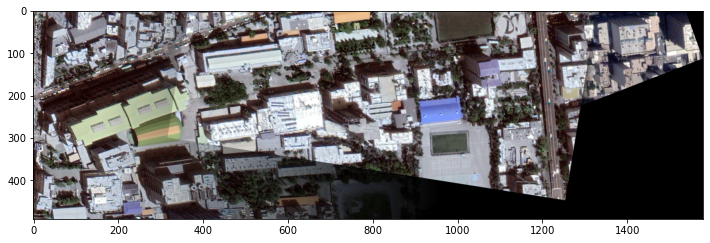

In [49]:
img = main('panoramaaaa.png','aut_1.png')

plt.figure(figsize=(12,8))
plt.imshow(normalize(img))

# part b

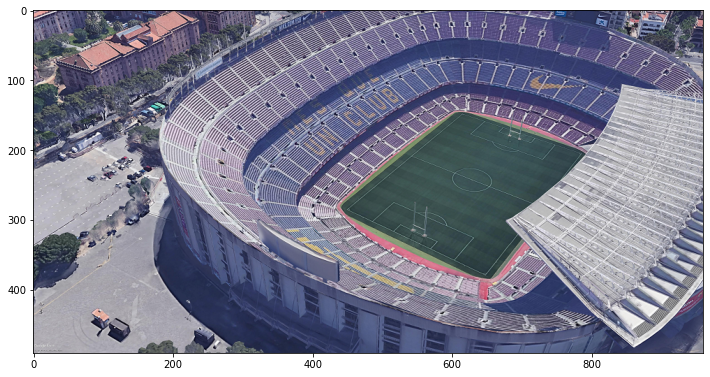

In [67]:
img = main('campnou_4.png','campnou_1.png')
cv2.imwrite('left.png', img)
plt.figure(figsize=(12,8))
plt.imshow(normalize(img))

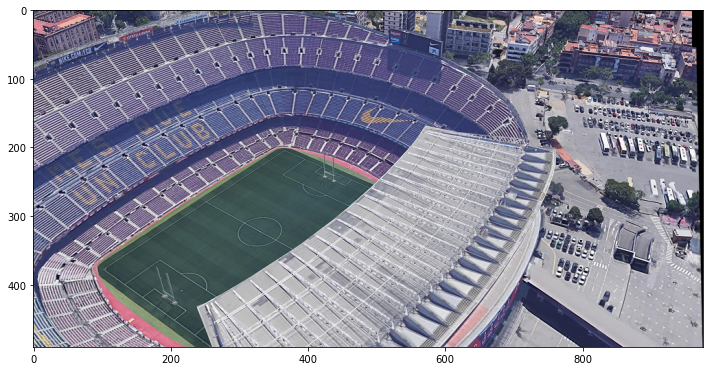

In [68]:
img = main('campnou_2.png','campnou_3.png')
cv2.imwrite('right.png', img )
plt.figure(figsize=(12,8))
plt.imshow(normalize(img))

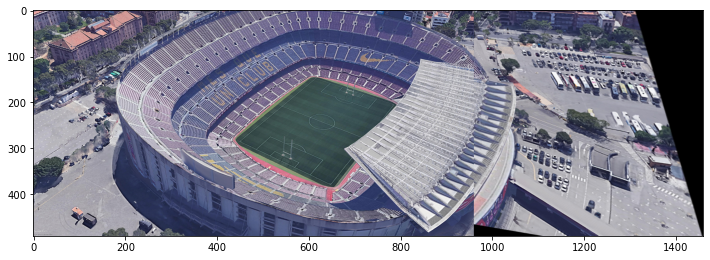

In [75]:
right = cv2.imread('right.png')
right = cv2.cvtColor(right, cv2.COLOR_BGR2RGB)
cv2.imwrite('right1.png', right)

left = cv2.imread('left.png')
left = cv2.cvtColor(left, cv2.COLOR_BGR2RGB)
cv2.imwrite('left1.png', left)

img = main('left1.png','right1.png')
cv2.imwrite('panorama22.png', img)
plt.figure(figsize=(12,8))
plt.imshow(normalize(img))

# part a&b new code

In [4]:
import numpy as np
import imutils
import cv2

class Panaroma:

    def image_stitch(self, images, lowe_ratio=0.75, max_Threshold=4.0,match_status=False):

        #detect the features and keypoints from SIFT
        (imageB, imageA) = images
        (KeypointsA, features_of_A) = self.Detect_Feature_And_KeyPoints(imageA)
        (KeypointsB, features_of_B) = self.Detect_Feature_And_KeyPoints(imageB)

        #got the valid matched points
        Values = self.matchKeypoints(KeypointsA, KeypointsB,features_of_A, features_of_B, lowe_ratio, max_Threshold)

        if Values is None:
            return None

        #to get perspective of image using computed homography
        (matches, Homography, status) = Values
        result_image = self.getwarp_perspective(imageA,imageB,Homography)
        result_image[0:imageB.shape[0], 0:imageB.shape[1]] = imageB

        # check to see if the keypoint matches should be visualized
        if match_status:
            vis = self.draw_Matches(imageA, imageB, KeypointsA, KeypointsB, matches,status)

            return (result_image, vis)

        return result_image

    def getwarp_perspective(self,imageA,imageB,Homography):
        val = imageA.shape[1] + imageB.shape[1]
        result_image = cv2.warpPerspective(imageA, Homography, (val , imageA.shape[0]))

        return result_image

    def Detect_Feature_And_KeyPoints(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # detect and extract features from the image
        descriptors = cv2.xfeatures2d.SIFT_create()
        (Keypoints, features) = descriptors.detectAndCompute(image, None)

        Keypoints = np.float32([i.pt for i in Keypoints])
        return (Keypoints, features)

    def get_Allpossible_Match(self,featuresA,featuresB):

        # compute the all matches using euclidean distance and opencv provide
        #DescriptorMatcher_create() function for that
        match_instance = cv2.DescriptorMatcher_create("BruteForce")
        All_Matches = match_instance.knnMatch(featuresA, featuresB, 2)

        return All_Matches

    def All_validmatches(self,AllMatches,lowe_ratio):
        #to get all valid matches according to lowe concept..
        valid_matches = []

        for val in AllMatches:
            if len(val) == 2 and val[0].distance < val[1].distance * lowe_ratio:
                valid_matches.append((val[0].trainIdx, val[0].queryIdx))

        return valid_matches

    def Compute_Homography(self,pointsA,pointsB,max_Threshold):
        #to compute homography using points in both images

        (H, status) = cv2.findHomography(pointsA, pointsB, cv2.RANSAC, max_Threshold)
        return (H,status)

    def matchKeypoints(self, KeypointsA, KeypointsB, featuresA, featuresB,lowe_ratio, max_Threshold):

        AllMatches = self.get_Allpossible_Match(featuresA,featuresB);
        valid_matches = self.All_validmatches(AllMatches,lowe_ratio)

        if len(valid_matches) > 4:
            # construct the two sets of points
            pointsA = np.float32([KeypointsA[i] for (_,i) in valid_matches])
            pointsB = np.float32([KeypointsB[i] for (i,_) in valid_matches])

            (Homograpgy, status) = self.Compute_Homography(pointsA, pointsB, max_Threshold)

            return (valid_matches, Homograpgy, status)
        else:
            return None

    def get_image_dimension(self,image):
        (h,w) = image.shape[:2]
        return (h,w)

    def get_points(self,imageA,imageB):

        (hA, wA) = self.get_image_dimension(imageA)
        (hB, wB) = self.get_image_dimension(imageB)
        vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
        vis[0:hA, 0:wA] = imageA
        vis[0:hB, wA:] = imageB

        return vis


    def draw_Matches(self, imageA, imageB, KeypointsA, KeypointsB, matches, status):

        (hA,wA) = self.get_image_dimension(imageA)
        vis = self.get_points(imageA,imageB)

        # loop over the matches
        for ((trainIdx, queryIdx), s) in zip(matches, status):
            if s == 1:
                ptA = (int(KeypointsA[queryIdx][0]), int(KeypointsA[queryIdx][1]))
                ptB = (int(KeypointsB[trainIdx][0]) + wA, int(KeypointsB[trainIdx][1]))
                cv2.line(vis, ptA, ptB, (0, 255, 0), 1)

        return vis

In [98]:
import imutils
import cv2

#Take picture from folder like: Hill1 & Hill2, scene1 & scene2, my1 & my2, taj1 & taj2, lotus1 & lotus2, beach1 & beach2, room1 & room2

print("Enter the number of images you want to concantenate:")
no_of_images = int(3)
print("Enter the image name in order of left to right in way of concantenation:")
#like taj1.jpg, taj2.jpg, taj3.jpg .... tajn.jpg
filename = ['aut_3.png','aut_2.png','aut_1.png']

for i in range(no_of_images):
    print("Enter the %d image:" %(i+1))
    filename.append(input())

images = []

for i in range(no_of_images):
    images.append(cv2.imread(filename[i]))

#We need to modify the image resolution and keep our aspect ratio use the function imutils
for i in range(no_of_images):
    images[i] = imutils.resize(images[i], width=400)

for i in range(no_of_images):
    images[i] = imutils.resize(images[i], height=400)



panaroma = Panaroma()
if no_of_images==2:
    (result, matched_points) = panaroma.image_stitch([images[0], images[1]], match_status=True)
else:
    (result, matched_points) = panaroma.image_stitch([images[no_of_images-2], images[no_of_images-1]], match_status=True)
    for i in range(no_of_images - 2):
        (result, matched_points) = panaroma.image_stitch([images[no_of_images-i-3],result], match_status=True)

#to show the got panaroma image and valid matched points
for i in range(no_of_images):
    cv2.imshow("Image {k}".format(k=i+1), images[i])

cv2.imshow("Keypoint Matches", matched_points)
cv2.imshow("Panorama", result)
#to write the images
cv2.imwrite("Matched_points.jpg",matched_points)
cv2.imwrite("Panorama_image.jpg",result)

cv2.waitKey(0)
cv2.destroyAllWindows()

Enter the number of images you want to concantenate:
Enter the image name in order of left to right in way of concantenation:
Enter the 1 image:
1
Enter the 2 image:
2
Enter the 3 image:
3


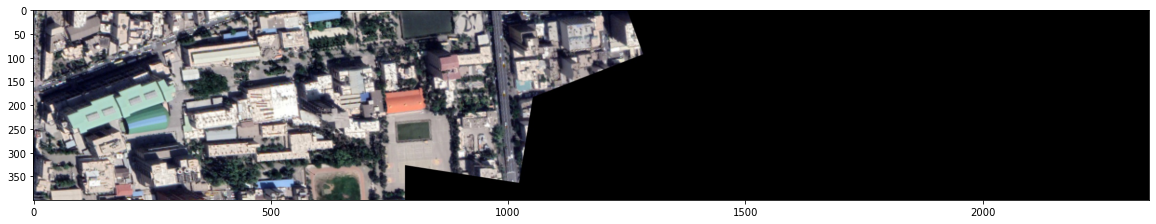

In [3]:
nasir_and_wives = cv2.imread("Panorama_image.jpg")
nasir_and_wives = cv2.cvtColor(nasir_and_wives, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
plt.imshow(nasir_and_wives)

In [78]:
import imutils
import cv2

#Take picture from folder like: Hill1 & Hill2, scene1 & scene2, my1 & my2, taj1 & taj2, lotus1 & lotus2, beach1 & beach2, room1 & room2

print("Enter the number of images you want to concantenate:")
no_of_images = int(2)
print("Enter the image name in order of left to right in way of concantenation:")
#like taj1.jpg, taj2.jpg, taj3.jpg .... tajn.jpg
filename = ['campnou_2.png','campnou_3.png']


for i in range(no_of_images):
    print("Enter the %d image:" %(i+1))
    filename.append(input())

images = []

for i in range(no_of_images):
    images.append(cv2.imread(filename[i]))


panaroma = Panaroma()
if no_of_images==2:
    (result, matched_points) = panaroma.image_stitch([images[0], images[1]], match_status=True)
else:
    (result, matched_points) = panaroma.image_stitch([images[no_of_images-2], images[no_of_images-1]], match_status=True)
    for i in range(no_of_images - 2):
        (result, matched_points) = panaroma.image_stitch([images[no_of_images-i-3],result], match_status=True)

#to show the got panaroma image and valid matched points
for i in range(no_of_images):
    cv2.imshow("Image {k}".format(k=i+1), images[i])

cv2.imshow("Keypoint Matches", matched_points)
cv2.imshow("Panorama", result)
#to write the images
cv2.imwrite("Matched_points.jpg",matched_points)
cv2.imwrite("Panorama_image_1.jpg",result)

cv2.waitKey(0)
cv2.destroyAllWindows()

Enter the number of images you want to concantenate:
Enter the image name in order of left to right in way of concantenation:
Enter the 1 image:
1
Enter the 2 image:
2


In [80]:
import imutils
import cv2

#Take picture from folder like: Hill1 & Hill2, scene1 & scene2, my1 & my2, taj1 & taj2, lotus1 & lotus2, beach1 & beach2, room1 & room2

print("Enter the number of images you want to concantenate:")
no_of_images = int(2)
print("Enter the image name in order of left to right in way of concantenation:")
#like taj1.jpg, taj2.jpg, taj3.jpg .... tajn.jpg
filename = ['campnou_4.png','campnou_1.png']


for i in range(no_of_images):
    print("Enter the %d image:" %(i+1))
    filename.append(input())

images = []

for i in range(no_of_images):
    images.append(cv2.imread(filename[i]))


panaroma = Panaroma()
if no_of_images==2:
    (result, matched_points) = panaroma.image_stitch([images[0], images[1]], match_status=True)
else:
    (result, matched_points) = panaroma.image_stitch([images[no_of_images-2], images[no_of_images-1]], match_status=True)
    for i in range(no_of_images - 2):
        (result, matched_points) = panaroma.image_stitch([images[no_of_images-i-3],result], match_status=True)

#to show the got panaroma image and valid matched points
for i in range(no_of_images):
    cv2.imshow("Image {k}".format(k=i+1), images[i])

cv2.imshow("Keypoint Matches", matched_points)
cv2.imshow("Panorama", result)
#to write the images
cv2.imwrite("Matched_points.jpg",matched_points)
cv2.imwrite("Panorama_image_1.jpg",result)

cv2.waitKey(0)
cv2.destroyAllWindows()

Enter the number of images you want to concantenate:
Enter the image name in order of left to right in way of concantenation:
Enter the 1 image:
1
Enter the 2 image:
2


# part c

In [1]:
%matplotlib notebook

def getHomo(X, x, iterations=500, thresh=5):
    # Simliar to DLT
    maxCount = 0
    for i in range(iterations):
        idx = np.random.randint(X.shape[0], size=4)
        temp_X = X[idx]
        temp_x = x[idx]

        ax = np.concatenate((-temp_X, np.zeros((4, 3)), temp_x[:, 0:1]*temp_X), axis=1)
        ay = np.concatenate((np.zeros((4, 3)), -temp_X, temp_x[:, 1:]*temp_X), axis=1)
        M = np.concatenate((ax, ay), axis=0)
        u, s, v = np.linalg.svd(M)
        H = v[8].reshape(3, 3)
        
        tempCount = 0
        res = X.dot(H.T)
        res = np.divide(res, res[:, 2].reshape(-1, 1))
        err = np.linalg.norm(res[:, :2] - x, axis=1)
        tempCount = np.count_nonzero(err<thresh)

#         print('Random try', i+1, 'Points satisfied', tempCount)
        if tempCount > maxCount:
            bestH = H
            maxCount = tempCount
    
    return bestH
    
def keypts(im1, im2, ratio=0.4):
    
    # Calculating top 300 sift features for both the images
    sift = cv2.xfeatures2d.SIFT_create(200)
    kp1, desc1 = sift.detectAndCompute(im1, None)
    kp2, desc2 = sift.detectAndCompute(im2, None)
    
    # Finding strong matches between the 2 images using ratio testing
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(desc1, desc2, k=2)
    
    goodMatches = []
    for m, n in matches:
        if (m.distance/n.distance) < ratio:
            goodMatches.append(m)
    
    return kp1, kp2, goodMatches
    
def stitch(im1, im2):
    
    im1 = np.pad(im1, ((im1.shape[0], im1.shape[0]), (im1.shape[1], im1.shape[1]), (0, 0)), 'constant')
    
    # Matching points of the 2 images
    kp1, kp2, goodMatches = keypts(im1, im2)
    
    # Finding source points and destination points to compute the homography matrix
    src_pts = []
    dst_pts = []
    for i in range(len(goodMatches)):
        src_pts.append([kp2[goodMatches[i].trainIdx].pt[0], kp2[goodMatches[i].trainIdx].pt[1]])
        dst_pts.append([kp1[goodMatches[i].queryIdx].pt[0], kp1[goodMatches[i].queryIdx].pt[1]])
    src_pts = np.array(src_pts)
    dst_pts = np.array(dst_pts)
    src_pts = np.concatenate((src_pts, np.ones((src_pts.shape[0], 1))), axis=1)
    
    # Computing the homography matrix and applying
    h = getHomo(src_pts, dst_pts)
    warped = cv2.warpPerspective(im2, h, (im1.shape[1], im1.shape[0]))
    
    # Creating the final image
    warped[im1!=0] = 0
    final = cleanse(warped + im1) 
    
    return final

def cleanse(im):
    for i in range(im.shape[1]-1, 0, -1):
        if (im[:, i] != 0).any():
            im = im[:, :i]
            break
            
    for i in range(0, im.shape[1]):
        if (im[:, i] != 0).any():
            im = im[:, i:]
            break
            
    for i in range(0, im.shape[0]):
        if (im[i] != 0).any():
            im = im[i:]
            break
            
    for i in range(im.shape[0]-1, 0, -1):
        if (im[i] != 0).any():
            im = im[:i]
            break
    
    return im

def findRoot(images):
    numOfFeats = []
    for i in range(len(images)):
        temp = 0
        for j in range(len(images)):
            if i != j:
                kp1, kp2, goodMatches = keypts(images[i], images[j])
                temp += len(goodMatches)
        numOfFeats.append(temp)
    
    return np.argmax(np.array(numOfFeats))



<IPython.core.display.Javascript object>


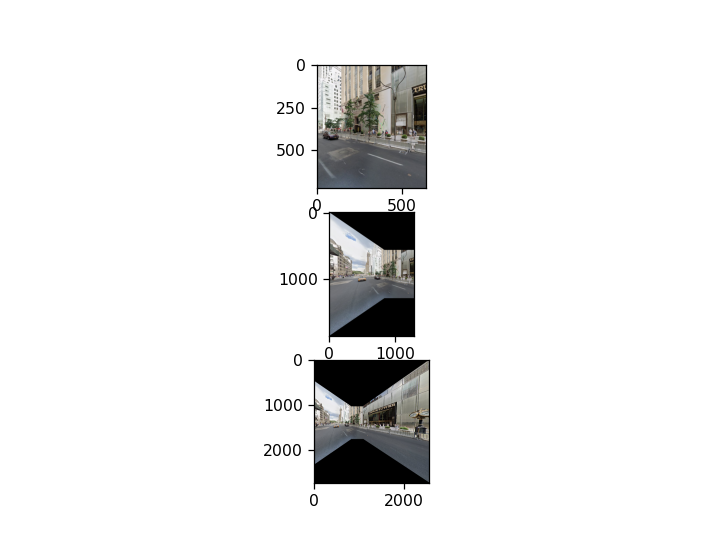

In [6]:
order = [1,2,3]
images = []
for i in order:
    images.append(cv2.imread('trump_tower_' + str(i) + '.png'))

root = findRoot(images) 
images[0], images[root] = images[root], images[0]

# Ordering algorithm
l = len(images)
plt.subplot(l, 1, 1)
plt.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
for i in range(l-1):
    maxLen = 0
    bestMatch = -1
    for j in range(1, len(images)):
        kp1, kp2, goodMatches = keypts(images[0], images[j])
        if len(goodMatches) > maxLen:
            maxLen = len(goodMatches)
            bestMatch = j
    
    images[0] = stitch(images[0], images[bestMatch])
    images.pop(bestMatch)
    
    plt.subplot(l, 1, i+2)
    plt.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
    cv2.imwrite("trump_tower_11.png",cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))